## EV Adoption Forecasting
As electric vehicle (EV) adoption surges, urban planners need to anticipate infrastructure needs—especially charging stations. Inadequate planning can lead to bottlenecks, impacting user satisfaction and hindering sustainability goals.

**Problem Statement:** Using the electric vehicle dataset (which includes information on EV populations, vehicle types, and possibly historical charging usage), create a model to forecast future EV adoption. For example, predict the number of electric vehicles in upcoming years based on the trends in the data.

**Goal:** Build a regression model that forecasts future EV adoption demand based on historical trends in EV growth, types of vehicles, and regional data.

**Dataset:** This dataset shows the number of vehicles that were registered by Washington State Department of Licensing (DOL) each month. The data is separated by county for passenger vehicles and trucks.

- Date: Counts of registered vehicles are taken on this day (the end of this month). - 2017-01-31
2024-02-29
- County: This is the geographic region of a state that a vehicle's owner is listed to reside within. Vehicles registered in Washington
- State: This is the geographic region of the country associated with the record. These addresses may be located in other
- Vehicle Primary Use: This describes the primary intended use of the vehicle.(Passenger-83%, Truck-17%)
- Battery Electric Vehicles (BEVs): The count of vehicles that are known to be propelled solely by an energy derived from an onboard electric battery.
- Plug-In Hybrid Electric Vehicles (PHEVs): The count of vehicles that are known to be propelled from energy partially sourced from an onboard electric battery
- Electric Vehicle (EV) Total: The sum of Battery Electric Vehicles (BEVs) and Plug-in Hybrid Electric Vehicles (PHEVs).
- Non-Electric Vehicle Total: The count of vehicles that are not electric vehicles.
- Total Vehicles: All powered vehicles registered in the county. This includes electric vehicles.
- Percent Electric Vehicles: Comparison of electric vehicles versus their non-electric counterparts.

**Dataset Link:** https://www.kaggle.com/datasets/sahirmaharajj/electric-vehicle-population-size-2024/data

### Import Required Libraries

### pip install pandas numpy matplotlib seaborn scikit-learn # global env

In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Load Dataset

In [2]:
df = pd.read_csv("Electric_Vehicle_Population_By_County.csv")

numeric_cols = [
    'Electric Vehicle (EV) Total',
    'Total Vehicles',
    'Non-Electric Vehicle Total',
    'Battery Electric Vehicles (BEVs)',
    'Plug-In Hybrid Electric Vehicles (PHEVs)'
]

for col in numeric_cols:
    df[col] = df[col].astype(str).str.replace(',', '')
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("Data types after conversion:")
print(df[numeric_cols].dtypes)

Data types after conversion:
Electric Vehicle (EV) Total                 int64
Total Vehicles                              int64
Non-Electric Vehicle Total                  int64
Battery Electric Vehicles (BEVs)            int64
Plug-In Hybrid Electric Vehicles (PHEVs)    int64
dtype: object


### Explore and Understand the Data

In [3]:
print("First 5 rows:")
display(df.head())

print("\nDataset shape:", df.shape)

print("\nData info:")
df.info()

print("\nMissing values:")
print(df.isnull().sum())

First 5 rows:


,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,September 30 2022,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,December 31 2022,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,January 31 2020,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,June 30 2022,Ferry,WA,Truck,0,0,0,3575,3575,0.00
4,July 31 2021,Douglas,CO,Passenger,0,1,1,83,84,1.19



Dataset shape: (20819, 10)

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20819 entries, 0 to 20818
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date                                      20819 non-null  object 
 1   County                                    20733 non-null  object 
 2   State                                     20733 non-null  object 
 3   Vehicle Primary Use                       20819 non-null  object 
 4   Battery Electric Vehicles (BEVs)          20819 non-null  int64  
 5   Plug-In Hybrid Electric Vehicles (PHEVs)  20819 non-null  int64  
 6   Electric Vehicle (EV) Total               20819 non-null  int64  
 7   Non-Electric Vehicle Total                20819 non-null  int64  
 8   Total Vehicles                            20819 non-null  int64  
 9   Percent Electric Vehicles                 20819 non-null  float64

Total 20819 data points and 10 features.

In [4]:
Q1 = df['Percent Electric Vehicles'].quantile(0.25)
Q3 = df['Percent Electric Vehicles'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print('Lower bound:', lower_bound)
print('Upper bound:', upper_bound)

outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Outliers in 'Percent Electric Vehicles':", outliers.shape[0])

Lower bound: -3.5174999999999996
Upper bound: 6.9025
Outliers in 'Percent Electric Vehicles': 2476


In [5]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df[df['Date'].notnull()]
df = df[df['Electric Vehicle (EV) Total'].notnull()]

df['County'] = df['County'].fillna('Unknown')
df['State'] = df['State'].fillna('Unknown')

df['Battery Electric Vehicles (BEVs)'] = df['Battery Electric Vehicles (BEVs)'].fillna(0)
df['Plug-In Hybrid Electric Vehicles (PHEVs)'] = df['Plug-In Hybrid Electric Vehicles (PHEVs)'].fillna(0)

print("\nMissing values after cleaning:")
print(df.isnull().sum())

print("\nFirst 5 rows after cleaning:")
display(df.head())

print("\nFinal dataset shape:", df.shape)


Missing values after cleaning:
Date                                        0
County                                      0
State                                       0
Vehicle Primary Use                         0
Battery Electric Vehicles (BEVs)            0
Plug-In Hybrid Electric Vehicles (PHEVs)    0
Electric Vehicle (EV) Total                 0
Non-Electric Vehicle Total                  0
Total Vehicles                              0
Percent Electric Vehicles                   0
dtype: int64

First 5 rows after cleaning:


,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,2022-09-30,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,2022-12-31,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,2020-01-31,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,2022-06-30,Ferry,WA,Truck,0,0,0,3575,3575,0.00
4,2021-07-31,Douglas,CO,Passenger,0,1,1,83,84,1.19



Final dataset shape: (20819, 10)


As we could see, only Percent Eletric Vehicles is numeric.

In [6]:
df['Percent Electric Vehicles'] = np.where(df['Percent Electric Vehicles'] > upper_bound, upper_bound,
                                 np.where(df['Percent Electric Vehicles'] < lower_bound, lower_bound, df['Percent Electric Vehicles']))

outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Outliers after capping:", outliers.shape[0])

Outliers after capping: 0


Missing values in County and State.

**Check if any column contain outliers.**

In [7]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter
df['Days'] = (df['Date'] - df['Date'].min()).dt.days
df['EV_Percentage'] = df['Electric Vehicle (EV) Total'] / df['Total Vehicles']
df['BEV_Ratio'] = df['Battery Electric Vehicles (BEVs)'] / (df['Electric Vehicle (EV) Total'] + 1e-6)

print("\nTime range:", df['Date'].min().date(), "to", df['Date'].max().date())
print("Days range:", df['Days'].min(), "to", df['Days'].max())
print("\nEngineered features sample:")
display(df[['Date', 'Days', 'EV_Percentage', 'BEV_Ratio']].head())


Time range: 2017-01-31 to 2024-02-29
Days range: 0 to 2585

Engineered features sample:


,Date,Days,EV_Percentage,BEV_Ratio
0,2022-09-30,2068,0.014989,1.000000
1,2022-12-31,2160,0.015707,0.333333
2,2020-01-31,1095,0.030303,0.000000
3,2022-06-30,1976,0.000000,0.000000
4,2021-07-31,1642,0.011905,0.000000


### Data Preprocessing

Basic Data Cleaning


Summary statistics:
       Electric Vehicle (EV) Total  Percent Electric Vehicles  EV_Percentage
count                 20819.000000               20819.000000   20819.000000
mean                    297.579855                   2.122378       0.041393
std                    2915.504792                   2.277542       0.110553
min                       0.000000                   0.000000       0.000000
25%                       1.000000                   0.390000       0.003911
50%                       1.000000                   1.220000       0.012195
75%                       4.000000                   2.995000       0.029925
max                   89834.000000                   6.902500       1.000000


C:\Users\Adithyakrishnan\AppData\Local\Temp\ipykernel_7112\3308148139.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counties.values, y=top_counties.index, palette="viridis")


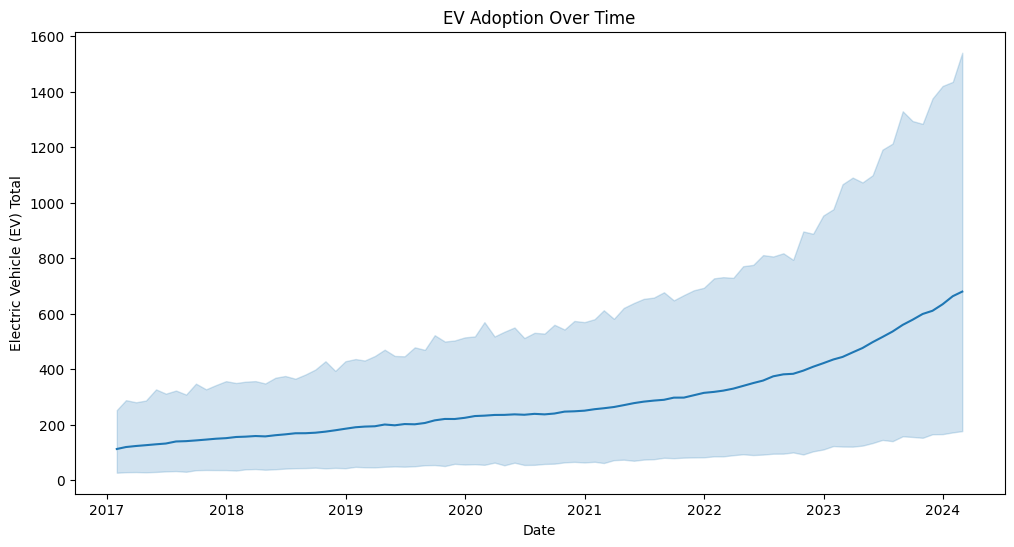

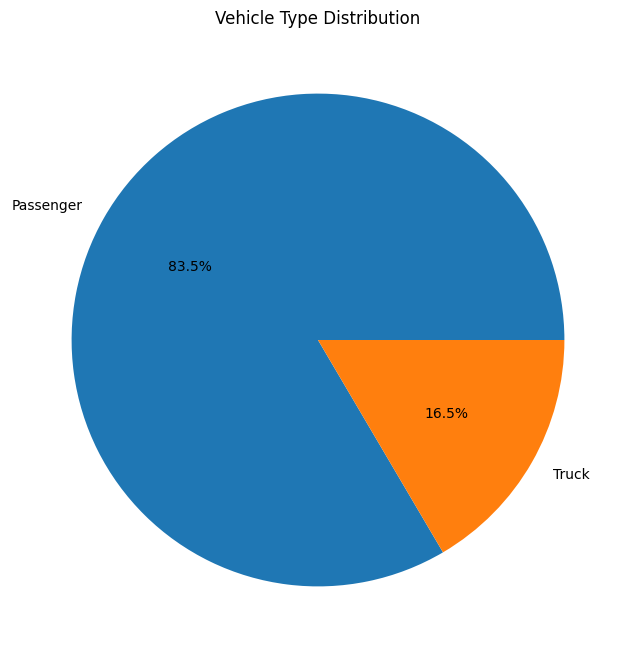

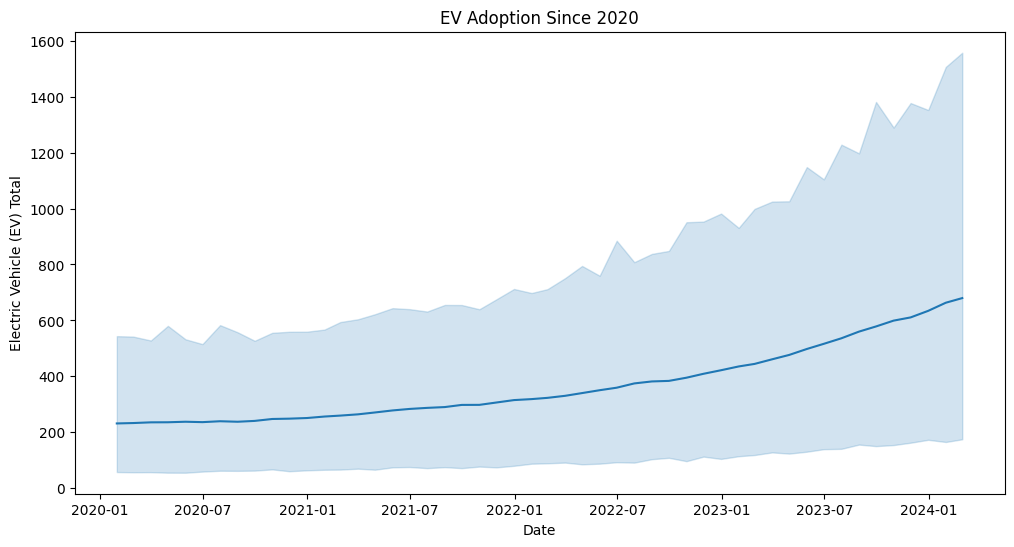

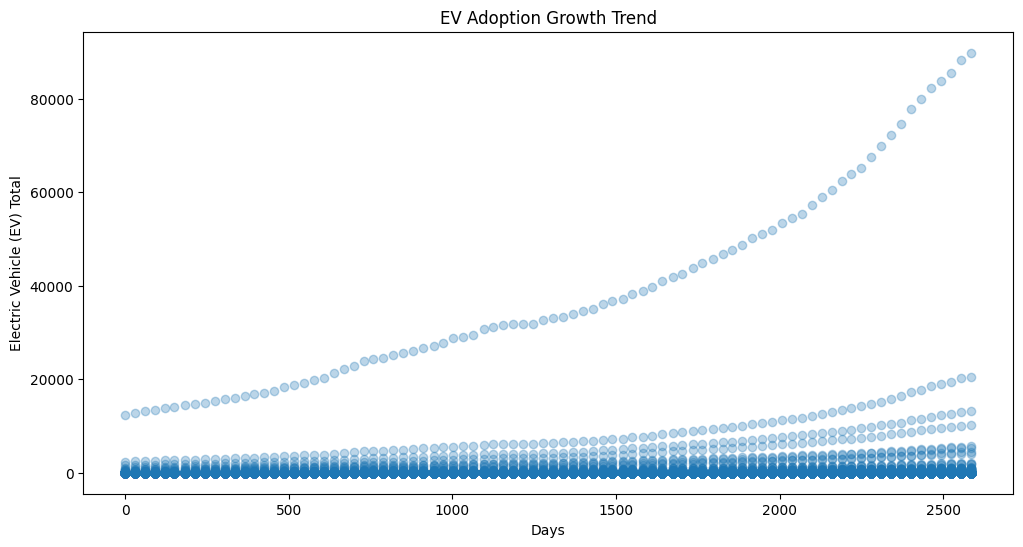

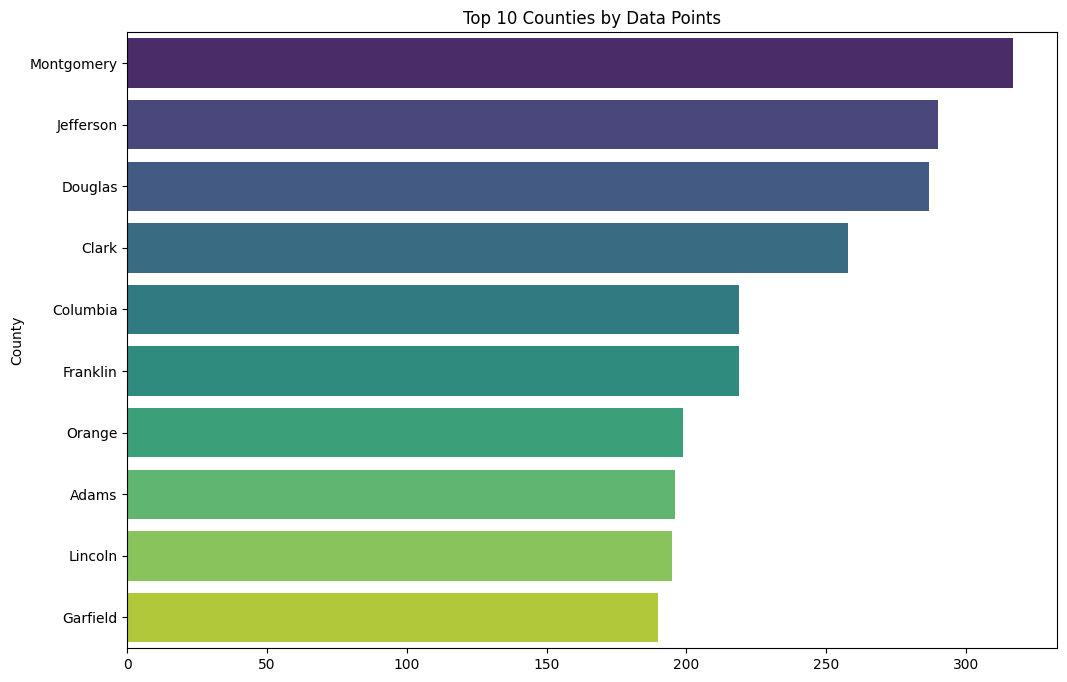

In [8]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='Date', y='Electric Vehicle (EV) Total')
plt.title('EV Adoption Over Time')
plt.savefig('ev_trend.png', dpi=300)

plt.figure(figsize=(8,8))
df['Vehicle Primary Use'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Vehicle Type Distribution')
plt.ylabel('')
plt.savefig('vehicle_types.png', dpi=300)

plt.figure(figsize=(12,6))
sns.lineplot(data=df[df['Year'] >= 2020], x='Date', y='Electric Vehicle (EV) Total')
plt.title('EV Adoption Since 2020')
plt.savefig('recent_trend.png', dpi=300)

plt.figure(figsize=(12,6))
sns.regplot(x='Days', y='Electric Vehicle (EV) Total', data=df, scatter_kws={'alpha':0.3})
plt.title('EV Adoption Growth Trend')
plt.savefig('growth_trend.png', dpi=300)

print("\nSummary statistics:")
print(df[['Electric Vehicle (EV) Total', 'Percent Electric Vehicles', 'EV_Percentage']].describe())
# === New: County Distribution ===
plt.figure(figsize=(12, 8))
top_counties = df['County'].value_counts().head(10)
sns.barplot(x=top_counties.values, y=top_counties.index, palette="viridis")
plt.title('Top 10 Counties by Data Points')
plt.savefig('top_counties.png', dpi=300)

Remove Outliers: Cap the values to the IQR bounds

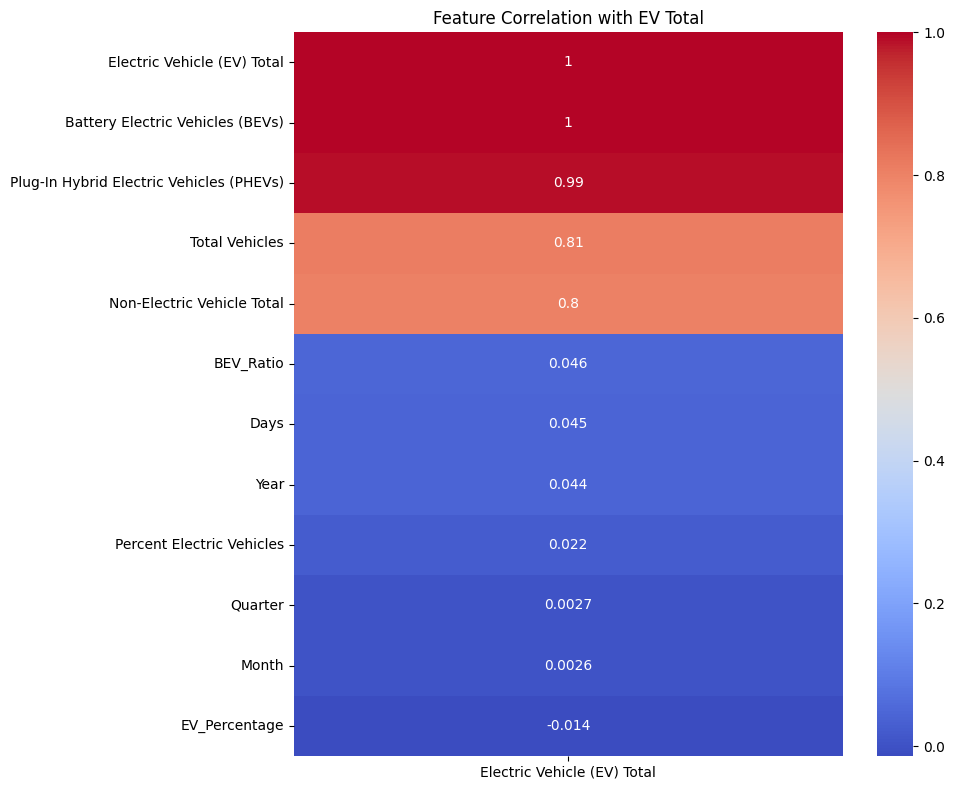

In [9]:
plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr[['Electric Vehicle (EV) Total']].sort_values(by='Electric Vehicle (EV) Total', ascending=False), 
            annot=True, cmap='coolwarm')
plt.title('Feature Correlation with EV Total')
plt.tight_layout()
plt.savefig('correlation.png', dpi=300)

In [10]:
# ====== WEEK 2 FEATURE ENGINEERING ======
# 1. County Encoding
le = LabelEncoder()
df['county_encoded'] = le.fit_transform(df['County'])

# 2. Time Index per County
df = df.sort_values(['County', 'Date'])
df['months_since_start'] = df.groupby('County').cumcount()

# 3. Lag Features
for lag in [1, 2, 3]:
    df[f'ev_total_lag{lag}'] = df.groupby('County')['Electric Vehicle (EV) Total'].shift(lag)

# 4. Rolling Metrics - FIXED PERCENTAGE CHANGE
df['ev_total_roll_mean_3'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                               .transform(lambda x: x.shift(1).rolling(3).mean())

# SAFE PERCENTAGE CHANGE IMPLEMENTATION
def safe_pct_change(series, periods=1):
    """Calculate percentage change with infinity/NaN protection"""
    changed = series.pct_change(periods=periods)
    return changed.replace([np.inf, -np.inf], 0).fillna(0)

df['ev_total_pct_change_1'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                                .transform(lambda x: safe_pct_change(x, 1))
                                
df['ev_total_pct_change_3'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                                .transform(lambda x: safe_pct_change(x, 3))

# 5. Growth Slope
df['cumulative_ev'] = df.groupby('County')['Electric Vehicle (EV) Total'].cumsum()

def safe_slope(x):
    """Calculate slope with length check"""
    if len(x) < 6:
        return np.nan
    return np.polyfit(range(len(x)), x, 1)[0]

df['ev_growth_slope'] = df.groupby('County')['cumulative_ev'] \
                          .transform(lambda x: x.rolling(6).apply(safe_slope, raw=False))

# 6. Final Cleaning
df = df.dropna()
df.to_csv('preprocessed_ev_data.csv', index=False)
print("Week 2 preprocessing complete! Saved as 'preprocessed_ev_data.csv'")

Week 2 preprocessing complete! Saved as 'preprocessed_ev_data.csv'


In [11]:
# ====== MODEL SETUP ======
features = [
    'county_encoded',
    'ev_total_lag1',
    'ev_total_lag2',
    'ev_total_lag3',
    'ev_total_roll_mean_3',
    'ev_total_pct_change_1',
    'ev_total_pct_change_3',
    'ev_growth_slope'
]
target = 'Electric Vehicle (EV) Total'

X = df[features]
y = df[target]

# Time-based split (no shuffling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [ ]:
# ====== CELL 12: INFINITY CHECK AND CLEANING ======
import numpy as np

# Check for infinity in features
print("Checking for infinite values:")
print(f"X_train - inf: {np.isinf(X_train.values).sum()}, -inf: {np.isneginf(X_train.values).sum()}")
print(f"X_test - inf: {np.isinf(X_test.values).sum()}, -inf: {np.isneginf(X_test.values).sum()}")

# Replace infinity with NaN then fill with 0
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

# Verify cleaning
print("\nAfter cleaning:")
print(f"X_train - inf: {np.isinf(X_train.values).sum()}, -inf: {np.isneginf(X_train.values).sum()}")
print(f"X_test - inf: {np.isinf(X_test.values).sum()}, -inf: {np.isneginf(X_test.values).sum()}")
# ====== CELL 13: MODEL TRAINING ======
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 15],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', None]
}

rf = RandomForestRegressor(random_state=42)

# Add error_score='raise' for better debugging
random_search = RandomizedSearchCV(
    rf, 
    param_dist, 
    n_iter=10, 
    cv=3, 
    n_jobs=-1, 
    verbose=1, 
    random_state=42,
    error_score='raise'  # Crucial for detailed error messages
)

random_search.fit(X_train, y_train)

model = random_search.best_estimator_
print(f"Best Params: {random_search.best_params_}")

Checking for infinite values:
X_train - inf: 0, -inf: 0
X_test - inf: 0, -inf: 0

After cleaning:
X_train - inf: 0, -inf: 0
X_test - inf: 0, -inf: 0
Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
# ====== EVALUATION ======
y_pred = model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

# Feature Importance
plt.figure(figsize=(10,6))
pd.Series(model.feature_importances_, index=features).sort_values().plot.barh()
plt.title('Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)

In [ ]:
# ====== SAVE MODEL ======
joblib.dump(model, 'forecasting_ev_model.pkl')
print("Model saved as 'forecasting_ev_model.pkl'")

# Test loading
test_model = joblib.load('forecasting_ev_model.pkl')
sample_pred = test_model.predict(X_test.iloc[:1])
print(f"Sample prediction: {sample_pred[0]:.1f} vs Actual: {y_test.iloc[0]}")

In [ ]:
# ====== FORECASTING EXAMPLE ======
def forecast_county(county_name, months=12):
    try:
        county_code = le.transform([county_name])[0]
        county_data = df[df['county_encoded'] == county_code].sort_values('Date')
        
        last_row = county_data.iloc[-1].copy()
        forecasts = []
        
        for i in range(1, months+1):
            # Prepare next month's features
            next_date = last_row['Date'] + pd.DateOffset(months=i)
            new_features = {
                'county_encoded': county_code,
                'ev_total_lag1': last_row['Electric Vehicle (EV) Total'],
                'ev_total_lag2': last_row['ev_total_lag1'],
                'ev_total_lag3': last_row['ev_total_lag2'],
                'ev_total_roll_mean_3': np.mean([last_row['ev_total_lag1'], 
                                               last_row['ev_total_lag2'],
                                               last_row['ev_total_lag3']]),
                'ev_total_pct_change_1': (last_row['Electric Vehicle (EV) Total'] - last_row['ev_total_lag1']) / last_row['ev_total_lag1'],
                'ev_total_pct_change_3': (last_row['Electric Vehicle (EV) Total'] - last_row['ev_total_lag3']) / last_row['ev_total_lag3'],
                'ev_growth_slope': last_row['ev_growth_slope']
            }
            
            # Predict and update
            forecast = model.predict(pd.DataFrame([new_features]))[0]
            forecasts.append(forecast)
            last_row = new_features.copy()
            last_row['Electric Vehicle (EV) Total'] = forecast
        
        # Plot results
        plt.figure(figsize=(10,6))
        plt.plot(county_data['Date'], county_data['Electric Vehicle (EV) Total'], 'b-', label='Historical')
        future_dates = pd.date_range(start=county_data['Date'].iloc[-1] + pd.DateOffset(months=1), periods=months, freq='M')
        plt.plot(future_dates, forecasts, 'r--', label='Forecast')
        plt.title(f'EV Adoption Forecast: {county_name}')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    except Exception as e:
        print(f"Error forecasting {county_name}: {str(e)}")

# Example usage
forecast_county('King', months=12)